In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# first_year = session.query(Measurement.date).first()[0]
# first_year

In [12]:
years = session.query(Measurement.date).order_by(Measurement.date.asc())[:10]
years

[('2010-01-01'),
 ('2010-01-01'),
 ('2010-01-01'),
 ('2010-01-01'),
 ('2010-01-01'),
 ('2010-01-01'),
 ('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-02'),
 ('2010-01-02')]

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_year = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
start_year = dt.datetime.strptime(latest_year, "%Y-%m-%d") - dt.timedelta(days = 365)

latest_year

'2017-08-23'

In [14]:
# Perform a query to retrieve the data and precipitation scores
precipitation_last_12_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_year).all()
precipitation_last_12_months[:5]



[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01)]

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_last_12_months, columns = ['date', 'precipitation'])
precipitation_df.set_index('date', inplace = True)
precipitation_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [16]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by = 'date')
precipitation_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


In [17]:
# print(start_year)
# print(type(start_year))
# print(f"latest_year: {latest_year}")
# print(f"type latest_year: {type(latest_year)}")
# print(f"precipitation_last_12_months: {precipitation_last_12_months[:3]}")
# precipitation_df[-1:-6:-1]
# # precipitation_df.head()

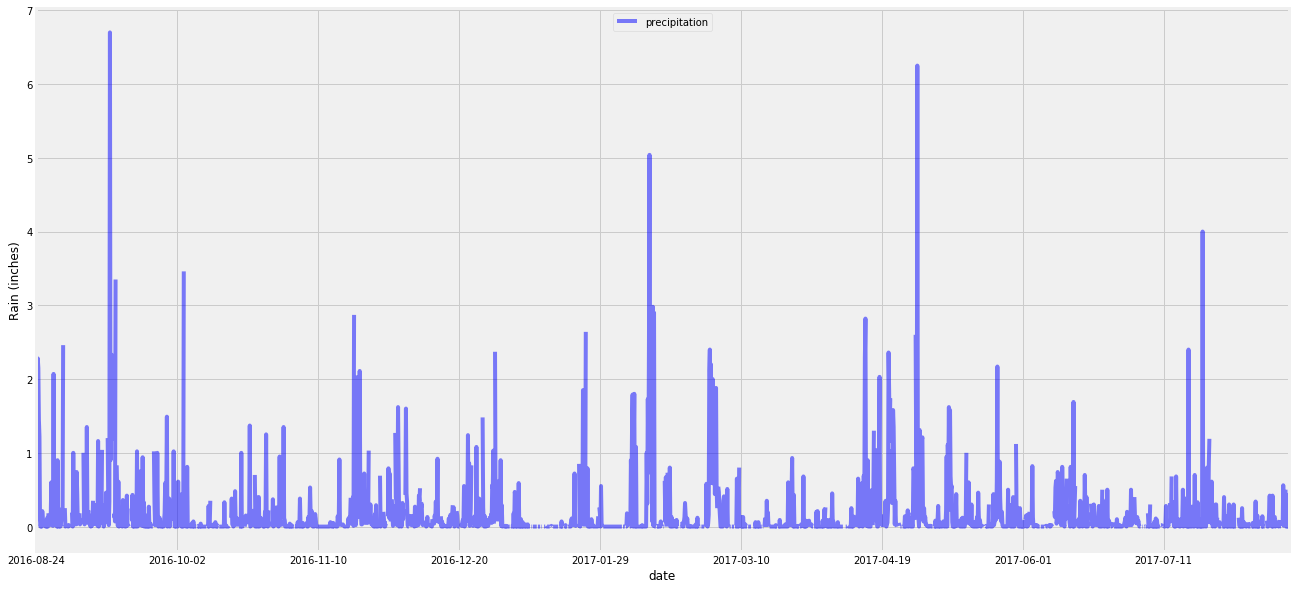

In [38]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(color='b', alpha=0.5, figsize=(20,10))

plt.legend(loc='upper center')
plt.ylabel("Rain (inches)")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station.id).count()
print(f"There are {number_of_stations} stations available in this dataset")


There are 9 stations available in this dataset


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = most_active_stations[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active).all()


[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
highest_temp_observations_station = session.query(Measurement.station, func.count(Measurement.tobs))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

highest_temp_observations_station

'USC00519281'

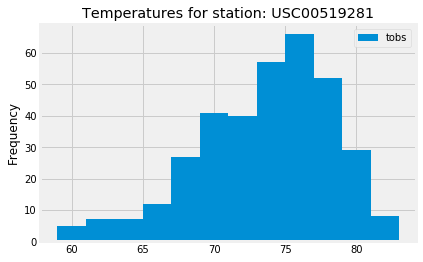

In [39]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12_highest_temp_observations_station = session.query(Measurement.station,Measurement.tobs)\
    .filter(Measurement.date >= start_year)\
    .filter(Measurement.station == highest_temp_observations_station).all()

last12_df = pd.DataFrame(last12_highest_temp_observations_station)

last12_df.plot.hist(bins = 12)

plt.ylabel("Frequency")
plt.title(f"Temperatures for station: {highest_temp_observations_station}")
plt.show()


![precipitation](Images/station-histogram.png)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2017-07-03'
trip_end_date = '2017-07-10'

trip_forecast = calc_temps(trip_start_date, trip_end_date)

In [28]:
trip_forecast

[(69.0, 78.12, 87.0)]

In [29]:
_min, _avg, _high = trip_forecast[0]

def forecast_report(m, a, h):
    print(f"Based on {trip_start_date[:4]} data, you can expect the following temperatures:")
    print(f"{'-'*62}")
    print(f"min of: {m} F")
    print(f"average of: {a} F")
    print(f"hight of: {h} F")

In [30]:
forecast_report(_min, _avg, _high)   

Based on 2017 data, you can expect the following temperatures:
--------------------------------------------------------------
min of: 69.0 F
average of: 78.12 F
hight of: 87.0 F


In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
forecast_df = pd.DataFrame(trip_forecast, columns = ['min_temp', 'avg_temp', 'high_temp'])
forecast_df

,min_temp,avg_temp,high_temp
0,69.0,78.12,87.0


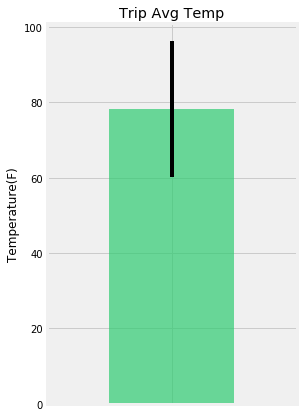

In [32]:
forecast_df.plot.bar(y= 'avg_temp', yerr= (forecast_df['high_temp'] - forecast_df['min_temp']),\
                     figsize=(4,7), color='#2ECC71', alpha=0.7, legend=None)

plt.tick_params(labelbottom=False)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature(F)')
plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_date = '2017-07-03'
trip_end_date = '2017-07-10'

rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start_date).\
    filter(Measurement.date <= trip_end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_df = pd.DataFrame(rainfall, columns=['station','name','latitude','longitude','elevation','prcp'])
rainfall_df

,station,name,latitude,longitude,elevation,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.76
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.54
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.29
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.08
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.06
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.02
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


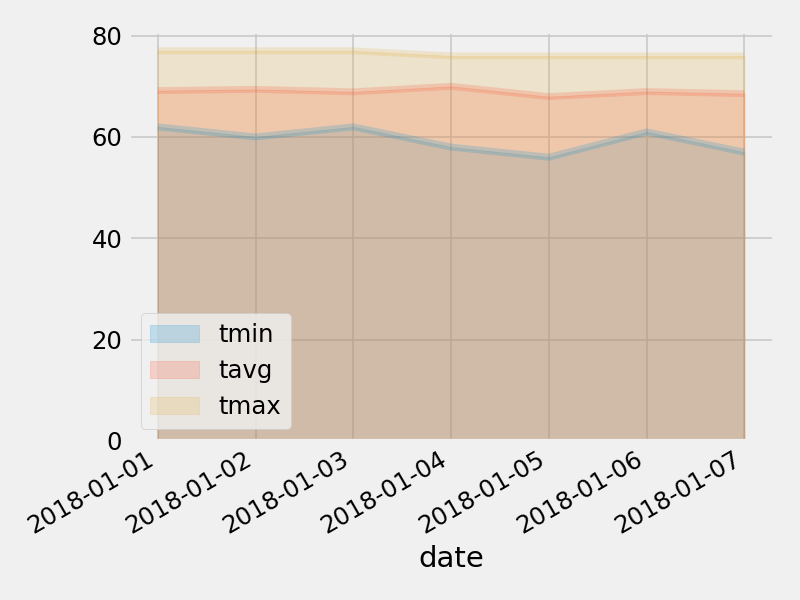

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
